# LTU-ILI: Append dummy data test

### Author:
  - [@CompiledAtBirth](https://github.com/CompiledAtBirth) (Nicolas Chartier)


## Summary

- This notebook aims at providing tests related to the issue [Issue34_ltu-ili](https://github.com/maho3/ltu-ili/issues/34), and in the next step should be integrated into a working example from the [@ltu-ili](https://github.com/maho3/ltu-ili) framework of the [Simons Collaboration on Learning the Universe](https://www.learning-the-universe.org).
- Topics: Parameter inference with Density Estimation, standard summary statistics from cosmological N-body simulations.
- Goal: Assess the capabilities of learning posterior distributions when the data vector has higher dimension. We consider two cases 1) When noise independent of the parameters to infer is present 2) When the data vector has much higher dimension and supposedly carries more information about the parameters.

## Tools and data

- The main tool is the simulation-based inference package [sbi](https://www.mackelab.org/sbi/).
- Basic knowledge about [PyTorch](https://pytorch.org/) is useful.
- We use some common packages: [ChainConsumer](https://samreay.github.io/ChainConsumer/), [Pandas](https://pandas.pydata.org/) and [netCDF4](https://unidata.github.io/netcdf4-python/).
- TARP validation metric from [Lemos et al, 2023](https://arxiv.org/abs/2302.03026)
- The data is from the publicly available [Quijote Simulations](https://quijote-simulations.readthedocs.io/en/latest/). Unless stated otherwise, all clustering statistics used here stem from the Latin Hypercube set with massless neutrinos.

## Literature and references (non-exhaustive)
- More details about the Quijote simulations in this [publication](https://arxiv.org/abs/1909.05273).
- Density estimation: publications related to Masked Autoregressive Flows [(MAF)](https://arxiv.org/abs/1705.07057) and Masked Autoencoder for Distribution Estimation [(MADE)](https://arxiv.org/abs/1502.03509). We build a model of the former by stacking instances of the latter.
- Sequential Neural Posterior Estimation (SNPE): [NeurIPS2016](https://proceedings.neurips.cc/paper_files/paper/2016/file/6aca97005c68f1206823815f66102863-Paper.pdf) for SNPE-A, [NeurIPS2017](https://proceedings.neurips.cc/paper_files/paper/2017/file/addfa9b7e234254d26e9c7f2af1005cb-Paper.pdf) for SNPE-B, [ICML2019](http://proceedings.mlr.press/v97/greenberg19a/greenberg19a.pdf) for SNPE-C and [NeurIPS2022](https://arxiv.org/pdf/2210.04815.pdf).
- Sequential Neural Likelihood Estimation (SNLE): Not used in this notebook, but for reference e.g. [AISTATS2019](http://proceedings.mlr.press/v89/papamakarios19a/papamakarios19a.pdf).
- General useful [review](https://arxiv.org/abs/1911.01429) about Simulation-Based Inference (SBI), also called Implicit-Likelihood Inference (ILI).

In [1]:
import numpy as np
import copy
import netCDF4 as nc
import matplotlib.pyplot as plt
import pandas as pd
import tqdm

# see Interface Usage examples at eg. https://www.mackelab.org/sbi/tutorial/02_flexible_interface/
import torch
from sbi import utils as utils
from sbi.inference import SNPE, SNLE_A, SNLE, likelihood_estimator_based_potential, MCMCPosterior

import tarp

from chainconsumer import ChainConsumer

In [3]:
from ili.dataloaders import StaticNumpyLoader
from ili.inference.runner_sbi import SBIRunner
from ili.validation.runner import ValidationRunner
from ili .validation.metrics import PlotSinglePosterior, TARP

In [4]:
help(tarp.get_drp_coverage)

Help on function get_drp_coverage in module tarp.drp:

get_drp_coverage(samples: numpy.ndarray, theta: numpy.ndarray, references: Union[str, numpy.ndarray] = 'random', metric: str = 'euclidean') -> Tuple[numpy.ndarray, numpy.ndarray]
    Estimates coverage with the distance to random point method.
    
    Reference: `Lemos, Coogan et al 2023 <https://arxiv.org/abs/2302.03026>`_
    
    Args:
        samples: the samples to compute the coverage of, with shape ``(n_samples, n_sims, n_dims)``.
        theta: the true parameter values for each samples, with shape ``(n_sims, n_dims)``.
        references: the reference points to use for the DRP regions, with shape
            ``(n_references, n_sims)``, or the string ``"random"``. If the later, then
            the reference points are chosen randomly from the unit hypercube over
            the parameter space.
        metric: the metric to use when computing the distance. Can be ``"euclidean"`` or
            ``"manhattan"``.
    
    R

In [5]:
help(SBIRunner.__call__)

Help on function __call__ in module ili.inference.runner_sbi:

__call__(self, loader, seed=None)
    Train your posterior and save it to file
    
    Args:
        loader (BaseLoader): data loader with stored summary-parameter pairs



In [6]:
# Setting pyTorch device as GPU if available, else CPU
deviceStr = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(deviceStr)
print('Using device:', device)

Using device: cpu


### Simulation summaries are from redshift z =0.5
In this collection of examples, we will be dealing with the Power Spectrum

In [7]:
dataDir = "/home/chartier/Documents/LTU_ILI/iliData/quijote_z0p5/"

# Cosmological parameters, fiducial values for prior
paramStr=[r"$\Omega_m$", r"$\Omega_b$",r"$h$",r"$n_s$",r"$\sigma_8$"]

# Means are Quijote fiducial parameters, and for the standard deviations I checked some literature
Om0 = 0.3175 ; s_Om0 = 0.0074
Ob0 = 0.049 ; s_Ob0 = 0.0003
h = 0.6711 ; s_h = 0.0054
n_s = 0.9424 ; s_ns = 0.0042
sigma_8 = 0.834 ; s_sigma_8 = 0.006

fiducial = np.array([Om0, Ob0, h, n_s, sigma_8])
factVariance = 1.0 # if we want to make Planck-like uncertaintes wider or thiner for Gaussian priors

# Arbitrary constraints parametrized with standard deviations for the test, should be more realistic given the cosmology literature
constraints = factVariance * np.array([s_Om0**2,s_Ob0**2,s_h**2,s_ns**2,s_sigma_8**2])
theta = np.float32(np.loadtxt(dataDir + "/latin_hypercube_params.txt", delimiter = " ", skiprows = 1))

## !!!!!!!!!
# For SNPE, we must distinguish the proposal prior with which the simulations were run to the prior in the Bayesian Inference
# Below are Quijote latin hypercube bounds
lowProp = np.array([0.1, 0.03, 0.5, 0.8, 0.6])
upProp = np.array([0.5, 0.07, 0.9, 1.2, 1.0])

# axis along which RSD has been computed (careful about confusions)
axRSD = 0

# Data Files
filePk = "Concatenated/PK_z0p5_RSD%i_kmax1p0.nc"%axRSD

From the Quijote Paper, we read in section 2.6:
"[...] we use a latin-hypercube where
we vary the value of Ωm between 0.1 and 0.5, Ωb be-
tween 0.03 and 0.07, h between 0.5 and 0.9, ns between
0.8 and 1.2, σ8 between 0.6 and 1.0 and keep fixed Mν
to 0.0 eV and w to -1"

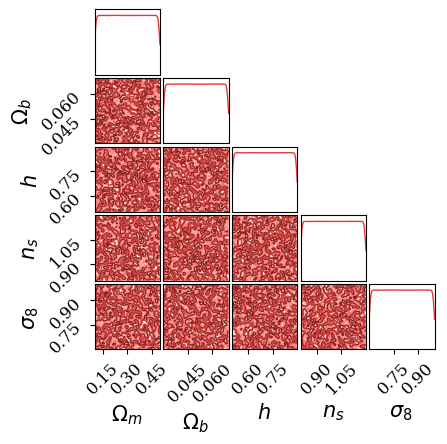

In [8]:
# In the LH, the marginal 1D contours should be close to uniform over the chosen ranges
cpre = ChainConsumer()
cpre.add_chain(theta, parameters = paramStr, name = "Cosmo LH", zorder = 1, color = "red")

cpre.configure(usetex = False,serif = True, shade=False, cloud = True, bar_shade=False,
            diagonal_tick_labels=True, tick_font_size=12, label_font_size=15, max_ticks=3,
            legend_kwargs={"loc": "upper right", "fontsize": 20},
            legend_color_text=True)
figpre = cpre.plotter.plot(figsize  =(4,4))

### Load the data

In [10]:
# Explore .nc format as training
pkData = nc.Dataset(dataDir +filePk)

# Individual dimensions are accessed via dat1.dimensions['x']
for group in pkData.groups.values():
    print(group)
    
# Just playing for netCDF4 related examples
pkLH = pkData["LH_z0p5"]
pkFid = pkData["fiducial_z0p5"]

# if we just just use Dataset.dimensions, just the names are shown without details
for dim in pkLH.dimensions.values():
  print(dim)

k3D = pkLH["k3D"]
ells = pkLH["multipole"]
seedsLH = pkLH["Seed"]
seedsFid = pkFid["Seed"]
print(pkLH["PkRSD_ax%i"%axRSD].shape)

<class 'netCDF4._netCDF4.Group'>
group /LH_z0p5:
    dimensions(sizes): Seed(2000), multipole(3), k3D(158)
    variables(dimensions): float64 k3D(k3D), int64 multipole(multipole), int64 Seed(Seed), float64 PkRSD_ax0(Seed, multipole, k3D)
    groups: 
<class 'netCDF4._netCDF4.Group'>
group /fiducial_z0p5:
    dimensions(sizes): Seed(500), multipole(3), k3D(158)
    variables(dimensions): float64 k3D(k3D), int64 multipole(multipole), int64 Seed(Seed), float64 PkRSD_ax0(Seed, multipole, k3D)
    groups: 
<class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'Seed', size = 2000
<class 'netCDF4._netCDF4.Dimension'>: name = 'multipole', size = 3
<class 'netCDF4._netCDF4.Dimension'>: name = 'k3D', size = 158
(2000, 3, 158)


# I) Power spectrum LH data only, SNPE on 3 parameters
## I-1) MDN only, inflence of true proposal prior with pre-run simulations

**About density_estimator argument when instanciating SNPE or SNLE from sbi.inference**

 density_estimator: If it is a string, use a pre-configured network of the
 |              provided type (one of nsf, maf, mdn, made). Alternatively, a function
 |              that builds a custom neural network can be provided. The function will
 |              be called with the first batch of simulations (theta, x), which can
 |              thus be used for shape inference and potentially for z-scoring. It
 |              needs to return a PyTorch `nn.Module` implementing the density
 |              estimator. The density estimator needs to provide the methods
 |              `.log_prob` and `.sample()`.


### Train and test data, using an ili BaseLoader class
To compute the TARP metric (https://arxiv.org/abs/2302.03026), we actually need a subset of the simulations playing the role of test data.

In [11]:
# Let's do an inference test on Om, sigma8 and h only for the moment
chosenStr = [r"$\Omega_m$",r"$h$",r"$\sigma_8$"]
res = [i for i, val in enumerate(paramStr) if val in set(chosenStr)]
num_dim = len(res)
print(res)
print(fiducial[res])

[0, 2, 4]
[0.3175 0.6711 0.834 ]


In [12]:
# For Validation metrics (TARP), set the number of training samples
n_train = 1800
n_test = len(seedsLH) - n_train

# Retrieve LH dataset as an array
pkLH_ell = pkLH["PkRSD_ax%i"%axRSD][:,ells==axRSD,:]
print(pkLH_ell.shape)
print(type(pkLH["PkRSD_ax%i"%axRSD]))
print(type(pkLH_ell))

# Idem for fiducial dataset, which we will use to compute fake observed data and evaluate a trained posterior distribution
pkFid_ell = pkFid["PkRSD_ax%i"%axRSD][:,ells==axRSD,:]
pk0 = np.mean(pkFid_ell, axis = 0)

# Prepare precomputed simulation-data pairs for StaticNumpyLoader class
# CAREFUL: Normally one would have of course to check the order of samples in pkTorch matches the order of parameter values in thetaTorch!
# In the .nc file, I already filled the variable corresponding to Pk in the same order as for the seeds in the Seed dimension
myTheta  = theta [:, res]

# Numpy Loader (redundance, but easier for the later examples)
loaderDir = "numpyLoader/"
np.save(loaderDir + "x_train.npy", np.array(pkLH_ell[:n_train,:]))
np.save(loaderDir + "x_test.npy", np.array(pkLH_ell[n_train:,:]))
np.save(loaderDir + "x_obs.npy", np.array(pk0))
np.save(loaderDir + "theta_obs.npy", np.array(fiducial[res]))
np.save(loaderDir + "theta_train.npy", myTheta[:n_train,:])
np.save(loaderDir + "theta_test.npy", myTheta[n_train:,:])

(2000, 158)
<class 'netCDF4._netCDF4.Variable'>
<class 'numpy.ma.core.MaskedArray'>


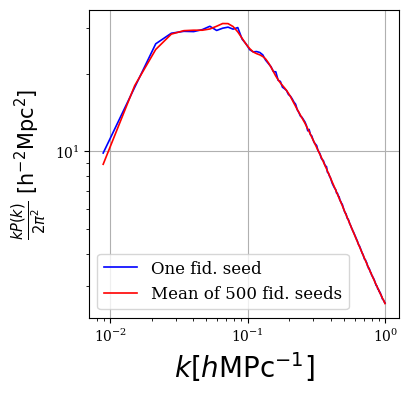

In [13]:
# Plot Pk monopole example and the fiducial mean for illustration
seedExample = 28
pkTest = pkFid_ell[seedExample,:]

plt.figure(figsize=(4,4))
plt.loglog(k3D[:], k3D[:]/(2*np.pi**2)*pkTest, linewidth=1.2, color = "blue", label = "One fid. seed")
plt.loglog(k3D[:],  k3D[:]/(2*np.pi**2)*pk0, linewidth=1.2, color = "red", label = "Mean of %i fid. seeds"%pkFid_ell.shape[0])
plt.xlabel(r'$k [h \rm{MPc}^{-1}]$',fontsize=20)
plt.ylabel(r"$\frac{kP(k)}{2\pi^2}$ $[{\rm h^{-2} Mpc^{2}}]$",fontsize = 15)
plt.legend(fontsize = 12, loc = "best")
plt.grid()

### Load data as BasicLoader instances
Here we directly instantiate the classes rather than using configuration files.

In [14]:
# reload all simulator data as a dataloader
train_loader = StaticNumpyLoader(in_dir = loaderDir, x_file = "x_train.npy", theta_file = "theta_train.npy")
test_loader = StaticNumpyLoader(in_dir = loaderDir, x_file = "x_test.npy", theta_file = "theta_test.npy")

In [15]:
runner_1p1 = SBIRunner.from_config("configs/training/training_1p1.yaml")

In [16]:
mySeed = 2023
runner_1p1(loader = train_loader, seed = mySeed)

INFO:root:Training model 1 out of 2 ensemble models


 Training neural network. Epochs trained: 95

INFO:root:Training model 2 out of 2 ensemble models


 Training neural network. Epochs trained: 13597 epochs.

/home/chartier/Modules/pySbiIli/lib/python3.10/site-packages/sbi/utils/posterior_ensemble.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._weights = torch.tensor(weights) / sum(weights)
INFO:root:It took 40.318145990371704 seconds to train all models.


 Neural network successfully converged after 136 epochs.

In [17]:
metrics_runner = ValidationRunner.from_config("configs/metrics/metrics_1p1.yaml")

In [18]:
metrics_runner.metrics

{'single_example': <ili.validation.metrics.PlotSinglePosterior at 0x7f5db237de70>,
 'tarp': <ili.validation.metrics.TARP at 0x7f5db237e5f0>}

Drawing 4593 posterior samples:   0%|          | 0/4593 [00:00<?, ?it/s]

Drawing 5407 posterior samples:   0%|          | 0/5407 [00:00<?, ?it/s]

/home/chartier/Modules/pySbiIli/lib/python3.10/site-packages/pyknos/mdn/mdn.py:283: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2189.)
  zero_mean_samples, _ = torch.triangular_solve(
100%|██████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 23.11it/s]
INFO:root:It took 16.927230834960938 seconds to run all metrics.


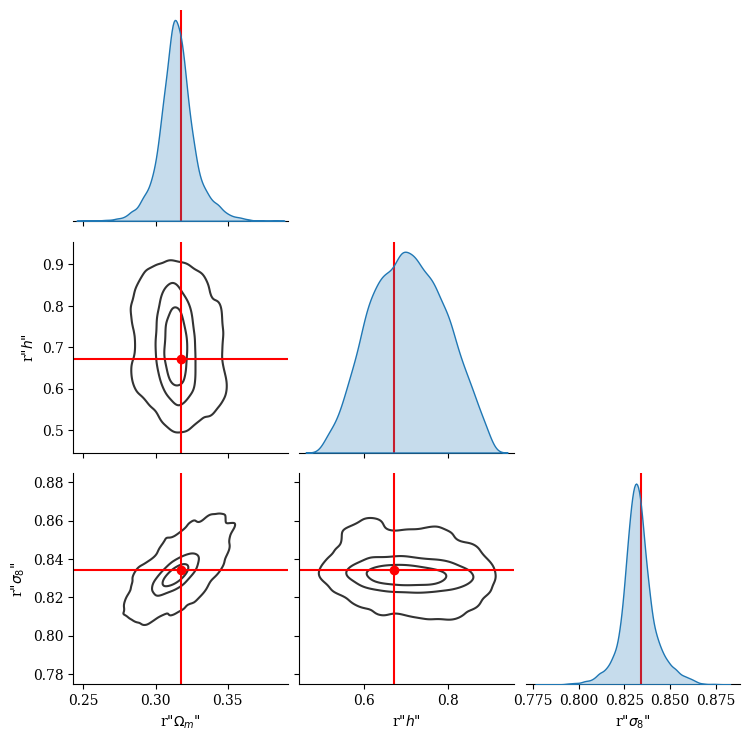

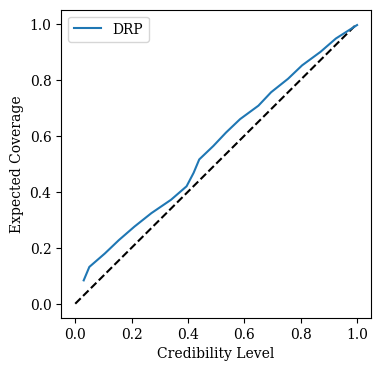

In [19]:
metrics_runner(loader = test_loader, x_obs = np.array(pk0), theta_obs = np.array(fiducial[res]))